In [1]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
df = pd.read_csv("Eluvio_DS_Challenge.csv", header=0)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## let's see the data

In [3]:
df.info() #not need to deal with missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
time_created    509236 non-null int64
date_created    509236 non-null object
up_votes        509236 non-null int64
down_votes      509236 non-null int64
title           509236 non-null object
over_18         509236 non-null bool
author          509236 non-null object
category        509236 non-null object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


In [4]:
df[df['over_18']==True] #super unbalance

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
1885,1206381438,2008-03-24,189,0,Pics from the Tibetan protests - more graphic ...,True,pressed,worldnews
6721,1211138718,2008-05-18,5,0,"MI5 linked to Max Mosley’s Nazi-style, sadomas...",True,alllie,worldnews
8414,1212694925,2008-06-05,0,0,Tabloid Horrifies Germany: Poland s Yellow Pre...,True,stesch,worldnews
12163,1216672016,2008-07-21,0,0,Love Parade Dortmund: Techno Festival Breaks R...,True,stesch,worldnews
12699,1217381380,2008-07-30,5,0,IDF kills young Palestinian boy. Potentially N...,True,cup,worldnews
...,...,...,...,...,...,...,...,...
503776,1477889966,2016-10-31,4,0,Latest Italian Earthquake Devastates Medieval ...,True,pixelinthe,worldnews
508067,1479400229,2016-11-17,12,0,ISIS Release Video Showing Melbourne As A Poss...,True,halacska,worldnews
508176,1479434681,2016-11-18,0,0,Animal welfare activists have released footage...,True,NinjaDiscoJesus,worldnews
508376,1479492875,2016-11-18,6,0,Jungle Justice : Public lynching of a street ...,True,avivi_,worldnews


In [5]:
df['category'].value_counts() 
#there is only one category, so we do not consider anything about cross-domain things
df = df.drop(['category'], axis=1)

### Which author has the most work? 

In [6]:
# Group by author and count the number of items
author_counts = df.groupby('author').count()['title'].to_frame('count')

# We'll take the top 30 authors
author_counts = author_counts.sort_values('count', ascending=False)
author_counts = author_counts.iloc[:30].reset_index()

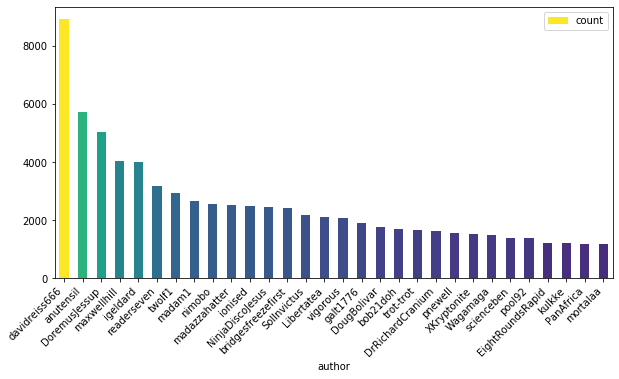

In [7]:
cmap = plt.cm.viridis
colors = cmap(author_counts['count'].values / float(author_counts['count'].max()))

# Make the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax = author_counts.plot.bar('author', 'count', color=colors, ax=ax)
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

#even though I will not do any task directly about authors, however it contains so much infomation
#in any task I would do.

### How has the work changed with time?

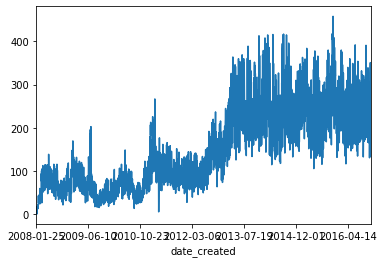

In [8]:
#by day
daily = df.groupby('date_created').count()['title'].to_frame()
ax = daily['title'].plot()

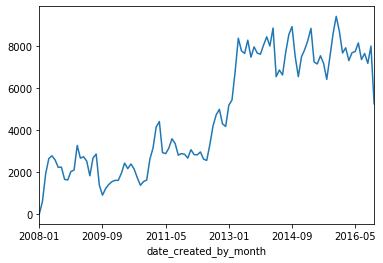

In [9]:
tmp_def = lambda x : "-".join(x.split("-")[:-1])

df['date_created_by_month'] = df['date_created'].apply(tmp_def)
monthly = df.groupby('date_created_by_month').count()['title'].to_frame()
ax = monthly['title'].plot()

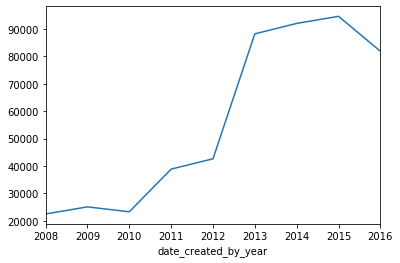

In [10]:
#by year
tmp_def = lambda x : x.split("-")[0]

df['date_created_by_year'] = df['date_created'].apply(tmp_def)
monthly = df.groupby('date_created_by_year').count()['title'].to_frame()
ax = monthly['title'].plot()

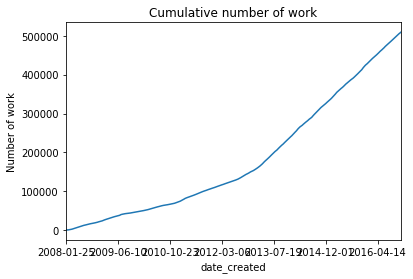

In [11]:
monthly = df.groupby('date_created').count()['title'].to_frame()
cumulative = np.cumsum(monthly.values)
monthly['cumulative'] = cumulative

# Now plot cumulative totals
ax = monthly['cumulative'].plot()
ax.set_title('Cumulative number of work')
ax.set_ylabel('Number of work')
df = df.drop(['date_created_by_month', 'date_created_by_year'], axis=1)

### What topics are covered in the titles? 

In [12]:
import wordcloud as wc 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [13]:
# We'll collect the titles and turn them into one giant string
titles = df['title'].values
titles = ' '.join(titles)

# Then define stop words to use...we'll include some "typical" brain words
our_stop_words = list(ENGLISH_STOP_WORDS)

In [14]:
# This function takes a buch of dummy arguments and returns random colors
def color_func(word=None, font_size=None, position=None,
               orientation=None, font_path=None, random_state=None):
    rand = np.clip(np.random.rand(), .2, None)
    cols = np.array(plt.cm.rainbow(rand)[:3])
    cols = cols * 255
    return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(*cols)

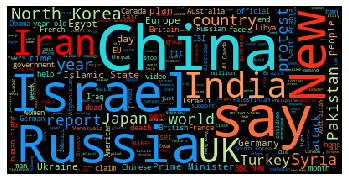

In [15]:
# Fit the cloud
cloud = wc.WordCloud(stopwords=our_stop_words,
                     color_func=color_func)
cloud.generate_from_text(titles)

# Now make a pretty picture
im = cloud.to_array()
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.viridis)
ax.set_axis_off()

### What does the overall "up_votes" and "down_votes" look like？

(array([5.01276e+05, 5.43800e+03, 1.98500e+03, 4.93000e+02, 3.70000e+01,
        4.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0. ,  2125.3,  4250.6,  6375.9,  8501.2, 10626.5, 12751.8,
        14877.1, 17002.4, 19127.7, 21253. ]),
 <a list of 10 Patch objects>)

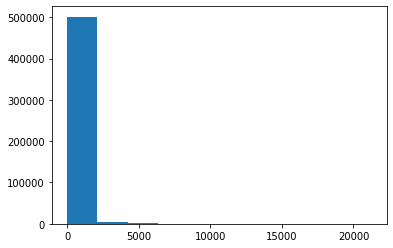

In [16]:
plt.hist(df['up_votes'])

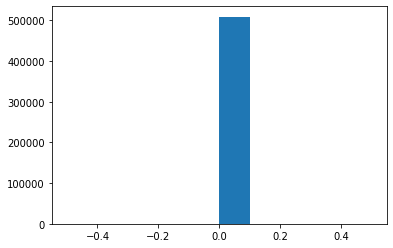

In [17]:
plt.hist(df['down_votes'])
df['down_votes'].value_counts()
# seems column "down_votes" would not provide us any useful info here, we can drop it.
df = df.drop(["down_votes"], axis=1)

### after data exploration 

#### So for now we can define my tasks. Since generally speaking it is a nlp related dataset, where we can use the title here to finish some interesting tasks. 

#### 1) We can do a classification task by treating column "over_18" as a label. The key here actually is how to deal with it's super-unbalance. 

#### 2) Since directly predict the up_votes num seems to be difficult and actually less needed, the second task can be a popularity-level prediction task. it will be much more reasonable and feasible because it is useful for recommendation, which is super-important for many companies.

#### Note the problem should be treated as large-scale, as the dataset is large (e.g. >100GB) and will not fit into the RAM of your machine. What's more, the "title" is only some short-text data which not has so much context for token. For speed and memory reason, I don't consider using bert related models here. In summary, I think for these two tasks, some great models that take big data into account are the optimal solution.

### reconstruct the dataset

In [18]:
def make_popularity_level(x):
    if x['up_votes'] < 5:
        return 0
    if x['up_votes'] < 20:
        return 1
    if x['up_votes'] < 100:
        return 2
    if x['up_votes'] < 500:
        return 3
    if x['up_votes'] < 5000:
        return 4
    else:
        return 5
df["popularity_level"] = df.apply(make_popularity_level, axis=1)
df.head()

,time_created,date_created,up_votes,title,over_18,author,popularity_level
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,0
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,0
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,0
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,0
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0


In [19]:
df['popularity_level'].value_counts() 

0    250398
1    145881
2     62560
3     27550
4     21152
5      1695
Name: popularity_level, dtype: int64

In [20]:
df = df.drop(['time_created', 'up_votes'], axis=1)
df.head()

,date_created,title,over_18,author,popularity_level
0,2008-01-25,Scores killed in Pakistan clashes,False,polar,0
1,2008-01-25,Japan resumes refuelling mission,False,polar,0
2,2008-01-25,US presses Egypt on Gaza border,False,polar,0
3,2008-01-25,Jump-start economy: Give health care to all,False,fadi420,0
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,False,mhermans,0


In [ ]:
df.to_csv("Eluvio_DS_Challenge_reconstruction.csv", index=0)

### task1: over_18 classification

In [4]:
import pandas as pd

df = pd.read_csv("Eluvio_DS_Challenge_reconstruction.csv")
df = df.drop(['popularity_level'], axis=1)
label_map = {True: 1, False: 0}
df['over_18'] = df['over_18'].map(label_map)
df.head()

,date_created,title,over_18,author
0,2008-01-25,Scores killed in Pakistan clashes,0,polar
1,2008-01-25,Japan resumes refuelling mission,0,polar
2,2008-01-25,US presses Egypt on Gaza border,0,polar
3,2008-01-25,Jump-start economy: Give health care to all,0,fadi420
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,0,mhermans


#### data prepocessing

In [5]:
import re

#use regular expressions remove some useless forms
def execute(x):
    temp=x
    pat1 = "[a-zA-Z]+'t"
    #substitude the ***'t' words with not ***
    temp = re.sub(pat1, 'not', temp)
    pat2 = "[a-zA-Z]+’t"

    temp = re.sub(pat2, 'not', temp)
    #email address
    pat3="[\w!#$%&'*+/=?^_`{|}~-]+(?:\.[\w!#$%&'*+/=?^_`{|}~-]+)*@(?:[\w](?:[\w-]*[\w])?\.)+[\w](?:[\w-]*[\w])?"
    temp = re.sub(pat3, 'email', temp)
    #url
    pat4="[a-zA-z]+://[^\s]*"
    temp = re.sub(pat4, 'url', temp)
    #date
    pat5="([0-9]{3}[1-9]|[0-9]{2}[1-9][0-9]{1}|[0-9]{1}[1-9][0-9]{2}|[1-9][0-9]{3})-(((0[13578]|1[02])-(0[1-9]|[12][0-9]|3[01]))|((0[469]|11)-(0[1-9]|[12][0-9]|30))|(02-(0[1-9]|[1][0-9]|2[0-8])))"
    temp = re.sub(pat5, 'date', temp)
    #number string
    pat6="[0-9]+"
    temp = re.sub(pat6, 'number', temp)
    return temp

def title_execute(x):
    return execute(x['title'])

df['title'] = df.apply(title_execute,axis=1)
df.head()

,date_created,title,over_18,author
0,2008-01-25,Scores killed in Pakistan clashes,0,polar
1,2008-01-25,Japan resumes refuelling mission,0,polar
2,2008-01-25,US presses Egypt on Gaza border,0,polar
3,2008-01-25,Jump-start economy: Give health care to all,0,fadi420
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,0,mhermans


In [6]:
import nltk
from itertools import chain

titles = df.title.values
y = df.over_18.values

title_word = []
for i in range(0, len(df)):
    title_word.append(str(titles[i]))
tokenized = [nltk.word_tokenize(word) for word in title_word]

In [7]:
#Calculation of both the most frequent words before and after the data cleaning

from nltk.corpus import stopwords
from string import punctuation
from collections import Counter

token_counter = Counter(token.lower() for sentences in tokenized for token in sentences)
top10 = token_counter.most_common()[:10]

print("before:")
for index, tok in enumerate(top10):
    print('{:>2}.{:>5}  freq: {:>7}'.format(index+1, tok[0], tok[1]))


def clean_text(tokenized_list, stopwords, punctuation, lemmatize=False):
    new_list = []
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc 
                         if token.lower() not in chain(stopwords, punctuation) 
                         and token.lower() != "'s" and token.lower() != "''" 
                         and token.lower() != "``" and token.lower() != "—"])
        # delete the expression like "'s"
    return new_list
stop_word = stopwords.words('english')
punct = punctuation + '’' + '‘' + '”' + '“'
cleaned_list = clean_text(tokenized, stop_word, punct)
# re-counter the token and list the new top10 most common words.
new_token_counter = Counter(token.lower() for sentences in cleaned_list for token in sentences)
new_top20 = new_token_counter.most_common()[:20]

print("\nafter:")
for index, tok in enumerate(new_top20):
    print('{:>2}.{:>5}  freq: {:>7}'.format(index+1, tok[0], tok[1]))

before:
 1.  the  freq:  211972
 2.   to  freq:  211659
 3.   in  freq:  207748
 4.    ,  freq:  195587
 5.   of  freq:  174341
 6.    .  freq:  128406
 7.number  freq:  118356
 8.    a  freq:  107661
 9.    s  freq:  103602
10.    :  freq:   87111

after:
 1.number  freq:  118356
 2.china  freq:   25759
 3. says  freq:   25415
 4.   us  freq:   23540
 5.  new  freq:   23329
 6.syria  freq:   18784
 7.russia  freq:   18114
 8.world  freq:   17857
 9.police  freq:   16583
10. iran  freq:   15474
11.israel  freq:   15455
12.government  freq:   15386
13.president  freq:   14709
14.killed  freq:   14319
15. u.s.  freq:   14033
16.people  freq:   13919
17.attack  freq:   12809
18.state  freq:   12554
19.  war  freq:   12328
20.military  freq:   11663


In [9]:
#for make full use of the column "date_created" and column "author", we need change these two column to some num. So

#1) i would calculate the time interval from this date to today, since there may be some special period where most of
#   work is over_18 or not over_18.
import datetime

def cal_interval(x):
    year, month, day = x['date_created'].split('-')
    d = datetime.datetime(int(year), int(month), int(day))
    return (datetime.datetime.now() - d).days

df['time_interval'] = df.apply(cal_interval, axis=1)

#2) i would simply use the total work num this author has for column "author", since maybe an author with more work
#   may be more likely have some over_18 work or less likely to do so.

author_work_num = df['author'].value_counts().to_list()
authors = df['author'].value_counts().index.to_list()

global authors_dict
authors_dict = {}
for i in range(len(authors)):
    authors_dict[authors[i]] = author_work_num[i]

def get_author_work_num(x):
    global authors_dict
    return authors_dict[x['author']]

df['author_work_num'] = df.apply(get_author_work_num, axis=1)

df = df.drop(['author', 'date_created'], axis=1)
df.head()

,title,over_18,time_interval,author_work_num
0,Scores killed in Pakistan clashes,0,4422,50
1,Japan resumes refuelling mission,0,4422,50
2,US presses Egypt on Gaza border,0,4422,50
3,Jump-start economy: Give health care to all,0,4422,2
4,Council of Europe bashes EU&UN terror blacklist,0,4422,1


In [15]:
df.tail()

,title,over_18,time_interval,author_work_num
509231,Heil Trump : Donald Trump s alt-right white...,0,1198,5
509232,There are people speculating that this could b...,0,1198,1
509233,Professor receives Arab Researchers Award,0,1198,3
509234,Nigel Farage attacks response to Trump ambassa...,0,1198,52
509235,Palestinian wielding knife shot dead in West B...,0,1198,177


In [17]:
#because these two column will be features in our model,
#of course we need some norm for time_interval and author_work_num
global mu, sigma

mu = df['time_interval'].mean()
sigma = df['time_interval'].std()

tmp_def = lambda x : ((x['time_interval'] - mu)/sigma)

df['time_interval'] = df.apply(tmp_def, axis=1)

mu = df['author_work_num'].mean()
sigma = df['author_work_num'].std()

tmp_def = lambda x : ((x['author_work_num'] - mu)/sigma)

df['author_work_num'] = df.apply(tmp_def, axis=1)

df.head()

,title,over_18,time_interval,author_work_num
0,Scores killed in Pakistan clashes,0,2.52401,-0.398278
1,Japan resumes refuelling mission,0,2.52401,-0.398278
2,US presses Egypt on Gaza border,0,2.52401,-0.398278
3,Jump-start economy: Give health care to all,0,2.52401,-0.429628
4,Council of Europe bashes EU&UN terror blacklist,0,2.52401,-0.430281


#### Build Gensim Doc2Vec (300 dimension)

In [39]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

class TagDocIterator:
    def __init__(self, doc_list, idx_list):
        self.doc_list = doc_list
        self.idx_list = idx_list

    def __iter__(self):
        for doc, idx, in zip(self.doc_list, self.idx_list):
            tag = [idx]
            yield TaggedDocument(words=doc, tags=tag)
doc2vec_model = Doc2Vec(size=300, epoch=5, window=7,hs=1,dbow_words=1,dm=1,workers=4)
doc2vec_model.build_vocab(TagDocIterator(cleaned_list, df.index))
doc2vec_model.train(TagDocIterator(cleaned_list, df.index), epochs=10, total_examples=doc2vec_model.corpus_count)
final_feature_text = []
for i in range(len(doc2vec_model.docvecs)):
    final_feature_text.append(doc2vec_model.docvecs[i])
final_feature_title = pd.DataFrame(final_feature_text)

/usr/local/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [40]:
final_feature_title.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.009551,0.041652,0.031554,-0.061443,0.032433,0.035705,0.102767,-0.101956,-0.041605,-0.077486,...,-0.106421,0.078112,-0.073253,-0.025195,-0.062856,-0.021881,-0.107622,0.046341,0.052798,-0.081791
1,-0.137073,-0.060530,0.080913,-0.029144,-0.050164,-0.059526,0.088287,0.034380,-0.107676,0.029540,...,0.050098,-0.060992,0.058993,-0.167155,-0.081609,-0.154604,-0.060728,-0.099312,0.057031,-0.016261
2,-0.019778,0.015820,0.099998,-0.061309,0.170608,-0.064783,0.006295,0.002290,0.022904,0.132631,...,0.107268,0.061135,0.026559,0.141778,-0.050201,0.051466,-0.038372,-0.031149,0.114362,-0.156829
3,-0.019090,0.014758,0.053727,-0.110529,-0.160245,0.026404,0.143440,0.072413,0.015956,-0.033835,...,-0.061437,0.081048,0.016262,-0.230955,0.024176,-0.072503,-0.146987,0.012403,-0.026176,-0.185485
4,0.129026,0.154224,0.039485,0.060047,0.155641,0.064512,-0.156133,-0.021201,0.053352,-0.000263,...,-0.187126,-0.139681,0.063137,-0.022159,0.092444,-0.203774,-0.041449,0.166458,-0.108928,0.203221


#### Building the Naive Doc2Vec

In [42]:
from nltk.corpus import gutenberg
from gensim import models
import numpy as np
# Training word2vec model on Gutenberg corpus. This may take a few minutes.
model = models.Word2Vec(cleaned_list,
                        size = 300,
                        window = 9,
                        min_count = 1,
                        sg = 1,
                        alpha = 0.025,
                        iter=10,
                        batch_words = 10000,
                       )


np.seterr(divide='ignore', invalid='ignore')
new_title_vectors_1 = np.zeros((len(df), 300))
for i in range(0, len(df)):
    # I find that a line has no title after we cleaned the punctuation and stopwords, so the length maybe 0
    if len(cleaned_list[i]) != 0:
        for word in cleaned_list[i]:
            new_title_vectors_1[i] += model.wv[word]
        # calculate the average of the word vector
        new_title_vectors_1[i] = new_title_vectors_1[i] / len(cleaned_list[i])

final_feature_w2v = pd.DataFrame(new_title_vectors_1)
final_feature_title.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.009551,0.041652,0.031554,-0.061443,0.032433,0.035705,0.102767,-0.101956,-0.041605,-0.077486,...,-0.106421,0.078112,-0.073253,-0.025195,-0.062856,-0.021881,-0.107622,0.046341,0.052798,-0.081791
1,-0.137073,-0.060530,0.080913,-0.029144,-0.050164,-0.059526,0.088287,0.034380,-0.107676,0.029540,...,0.050098,-0.060992,0.058993,-0.167155,-0.081609,-0.154604,-0.060728,-0.099312,0.057031,-0.016261
2,-0.019778,0.015820,0.099998,-0.061309,0.170608,-0.064783,0.006295,0.002290,0.022904,0.132631,...,0.107268,0.061135,0.026559,0.141778,-0.050201,0.051466,-0.038372,-0.031149,0.114362,-0.156829
3,-0.019090,0.014758,0.053727,-0.110529,-0.160245,0.026404,0.143440,0.072413,0.015956,-0.033835,...,-0.061437,0.081048,0.016262,-0.230955,0.024176,-0.072503,-0.146987,0.012403,-0.026176,-0.185485
4,0.129026,0.154224,0.039485,0.060047,0.155641,0.064512,-0.156133,-0.021201,0.053352,-0.000263,...,-0.187126,-0.139681,0.063137,-0.022159,0.092444,-0.203774,-0.041449,0.166458,-0.108928,0.203221


#### Concatenate the two(Gensim Doc2Vec, Naive Doc2Vec together)

In [25]:
final_feature_concat_tmp = pd.concat([final_feature_w2v,final_feature_title],axis=1)
final_feature_concat = pd.DataFrame(final_feature_concat_tmp.values)
final_feature_concat.head()

In [48]:
#final_feature_concat.to_pickle("Doc2Vec_and_NaiveDoc2Vec.pkl")

In [26]:
#final_feature_concat = pd.read_pickle('Doc2Vec_and_NaiveDoc2Vec.pkl')
final_feature_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.114142,-0.045430,0.076161,0.109428,0.270307,0.026597,0.254415,0.058721,0.080868,0.251980,...,-0.106421,0.078112,-0.073253,-0.025195,-0.062856,-0.021881,-0.107622,0.046341,0.052798,-0.081791
1,-0.153062,0.012015,-0.276221,0.289628,0.195618,0.009857,0.167317,0.199700,0.021019,-0.109926,...,0.050098,-0.060992,0.058993,-0.167155,-0.081609,-0.154604,-0.060728,-0.099312,0.057031,-0.016261
2,-0.278446,0.030214,-0.147669,-0.016307,0.170011,-0.123059,0.070555,0.078567,-0.012904,0.036337,...,0.107268,0.061135,0.026559,0.141778,-0.050201,0.051466,-0.038372,-0.031149,0.114362,-0.156829
3,-0.304994,0.158575,-0.068735,0.083358,-0.033279,0.000511,-0.134048,0.000989,-0.068883,-0.091709,...,-0.061437,0.081048,0.016262,-0.230955,0.024176,-0.072503,-0.146987,0.012403,-0.026176,-0.185485
4,-0.198066,-0.024537,0.061899,-0.032578,0.262839,-0.190344,0.063346,0.076915,0.088587,-0.024871,...,-0.187126,-0.139681,0.063137,-0.022159,0.092444,-0.203774,-0.041449,0.166458,-0.108928,0.203221


In [27]:
final_feature_concat = pd.concat([final_feature_concat, df['time_interval'], df['author_work_num']], axis=1)

In [58]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

train_1 = final_feature_concat
Y_1 = df['over_18'].as_matrix()


train_x_1, test_x_1, train_y_1, test_y_1 = train_test_split(train_1, Y_1, test_size=0.4, random_state=42)
evl_x_1, test_x_1, evl_y_1, test_y_1 = train_test_split(test_x_1, test_y_1, test_size=0.5, random_state=42)
train_x_1.shape, evl_x_1.shape, test_x_1.shape, train_y_1.shape, evl_y_1.shape, test_y_1.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


((305541, 602), (101847, 602), (101848, 602), (305541,), (101847,), (101848,))

#### for this task, the recall for over_18 work is really important. so our main goal is to return as more over_18 work as possible. after achieving this goal, we hope to return as less non_over_18 work as possible.

In [64]:
# just use the simple classification method in sklearn
from sklearn.metrics import classification_report
from sklearn import linear_model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

clf = linear_model.SGDClassifier(learning_rate="optimal", tol=1e-2, class_weight="balanced")
#we want deal with unbalance

# for memory issue we only use partial_fit but not fit
clf.partial_fit(train_x_1, train_y_1)
#clf.fit(train_x_1, train_y_1)
y_pred = clf.predict(evl_x_1)
y_pred= (y_pred>0.5)
print(metrics.accuracy_score(evl_y_1, y_pred),'\n')

matrix = metrics.confusion_matrix(evl_y_1,y_pred)
print(matrix,'\n')

print(classification_report(evl_y_1, y_pred))

0.9474309503470892 

[[96452  5338]
 [   16    41]] 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    101790
           1       0.01      0.72      0.02        57

    accuracy                           0.95    101847
   macro avg       0.50      0.83      0.49    101847
weighted avg       1.00      0.95      0.97    101847



In [65]:
# last we test in test set
y_pred = clf.predict(test_x_1)
y_pred= (y_pred>0.5)
print(metrics.accuracy_score(test_y_1, y_pred),'\n')

matrix = metrics.confusion_matrix(test_y_1,y_pred)
print(matrix,'\n')

print(classification_report(test_y_1, y_pred))

0.9480794910062054 

[[96511  5271]
 [   17    49]] 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    101782
           1       0.01      0.74      0.02        66

    accuracy                           0.95    101848
   macro avg       0.50      0.85      0.50    101848
weighted avg       1.00      0.95      0.97    101848



### task2: popularity-level prediction

In [4]:
import pandas as pd

df = pd.read_csv("Eluvio_DS_Challenge_reconstruction.csv")
df = df.drop(['over_18'], axis=1)
df

,date_created,title,author,popularity_level
0,2008-01-25,Scores killed in Pakistan clashes,polar,0
1,2008-01-25,Japan resumes refuelling mission,polar,0
2,2008-01-25,US presses Egypt on Gaza border,polar,0
3,2008-01-25,Jump-start economy: Give health care to all,fadi420,0
4,2008-01-25,Council of Europe bashes EU&UN terror blacklist,mhermans,0
...,...,...,...,...
509231,2016-11-22,Heil Trump : Donald Trump s alt-right white...,nonamenoglory,1
509232,2016-11-22,There are people speculating that this could b...,SummerRay,0
509233,2016-11-22,Professor receives Arab Researchers Award,AUSharjah,0
509234,2016-11-22,Nigel Farage attacks response to Trump ambassa...,smilyflower,0


#### all prepocessing things is the same with task1

In [6]:
import re

#use regular expressions remove some useless forms
def execute(x):
    temp=x
    pat1 = "[a-zA-Z]+'t"
    #substitude the ***'t' words with not ***
    temp = re.sub(pat1, 'not', temp)
    pat2 = "[a-zA-Z]+’t"

    temp = re.sub(pat2, 'not', temp)
    #email address
    pat3="[\w!#$%&'*+/=?^_`{|}~-]+(?:\.[\w!#$%&'*+/=?^_`{|}~-]+)*@(?:[\w](?:[\w-]*[\w])?\.)+[\w](?:[\w-]*[\w])?"
    temp = re.sub(pat3, 'email', temp)
    #url
    pat4="[a-zA-z]+://[^\s]*"
    temp = re.sub(pat4, 'url', temp)
    #date
    pat5="([0-9]{3}[1-9]|[0-9]{2}[1-9][0-9]{1}|[0-9]{1}[1-9][0-9]{2}|[1-9][0-9]{3})-(((0[13578]|1[02])-(0[1-9]|[12][0-9]|3[01]))|((0[469]|11)-(0[1-9]|[12][0-9]|30))|(02-(0[1-9]|[1][0-9]|2[0-8])))"
    temp = re.sub(pat5, 'date', temp)
    #number string
    pat6="[0-9]+"
    temp = re.sub(pat6, 'number', temp)
    return temp

def title_execute(x):
    return execute(x['title'])

df['title'] = df.apply(title_execute,axis=1)

import nltk
from itertools import chain

titles = df.title.values
y = df.popularity_level.values

title_word = []
for i in range(0, len(df)):
    title_word.append(str(titles[i]))
tokenized = [nltk.word_tokenize(word) for word in title_word]

#Calculation of both the most frequent words before and after the data cleaning

from nltk.corpus import stopwords
from string import punctuation
from collections import Counter

token_counter = Counter(token.lower() for sentences in tokenized for token in sentences)
top10 = token_counter.most_common()[:10]

print("before:")
for index, tok in enumerate(top10):
    print('{:>2}.{:>5}  freq: {:>7}'.format(index+1, tok[0], tok[1]))


def clean_text(tokenized_list, stopwords, punctuation, lemmatize=False):
    new_list = []
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc 
                         if token.lower() not in chain(stopwords, punctuation) 
                         and token.lower() != "'s" and token.lower() != "''" 
                         and token.lower() != "``" and token.lower() != "—"])
        # delete the expression like "'s"
    return new_list
stop_word = stopwords.words('english')
punct = punctuation + '’' + '‘' + '”' + '“'
cleaned_list = clean_text(tokenized, stop_word, punct)
# re-counter the token and list the new top10 most common words.
new_token_counter = Counter(token.lower() for sentences in cleaned_list for token in sentences)
new_top20 = new_token_counter.most_common()[:20]

print("\nafter:")
for index, tok in enumerate(new_top20):
    print('{:>2}.{:>5}  freq: {:>7}'.format(index+1, tok[0], tok[1]))
    

import datetime

def cal_interval(x):
    year, month, day = x['date_created'].split('-')
    d = datetime.datetime(int(year), int(month), int(day))
    return (datetime.datetime.now() - d).days

df['time_interval'] = df.apply(cal_interval, axis=1)


author_work_num = df['author'].value_counts().to_list()
authors = df['author'].value_counts().index.to_list()

global authors_dict
authors_dict = {}
for i in range(len(authors)):
    authors_dict[authors[i]] = author_work_num[i]

def get_author_work_num(x):
    global authors_dict
    return authors_dict[x['author']]

df['author_work_num'] = df.apply(get_author_work_num, axis=1)

df = df.drop(['author', 'date_created'], axis=1)
df.head()

before:
 1.  the  freq:  211972
 2.   to  freq:  211659
 3.   in  freq:  207748
 4.    ,  freq:  195587
 5.   of  freq:  174341
 6.    .  freq:  128406
 7.number  freq:  118356
 8.    a  freq:  107661
 9.    s  freq:  103602
10.    :  freq:   87111

after:
 1.number  freq:  118356
 2.china  freq:   25759
 3. says  freq:   25415
 4.   us  freq:   23540
 5.  new  freq:   23329
 6.syria  freq:   18784
 7.russia  freq:   18114
 8.world  freq:   17857
 9.police  freq:   16583
10. iran  freq:   15474
11.israel  freq:   15455
12.government  freq:   15386
13.president  freq:   14709
14.killed  freq:   14319
15. u.s.  freq:   14033
16.people  freq:   13919
17.attack  freq:   12809
18.state  freq:   12554
19.  war  freq:   12328
20.military  freq:   11663


,title,popularity_level,time_interval,author_work_num
0,Scores killed in Pakistan clashes,0,4422,50
1,Japan resumes refuelling mission,0,4422,50
2,US presses Egypt on Gaza border,0,4422,50
3,Jump-start economy: Give health care to all,0,4422,2
4,Council of Europe bashes EU&UN terror blacklist,0,4422,1


In [7]:
global mu, sigma

mu = df['time_interval'].mean()
sigma = df['time_interval'].std()

tmp_def = lambda x : ((x['time_interval'] - mu)/sigma)

df['time_interval'] = df.apply(tmp_def, axis=1)

mu = df['author_work_num'].mean()
sigma = df['author_work_num'].std()

tmp_def = lambda x : ((x['author_work_num'] - mu)/sigma)

df['author_work_num'] = df.apply(tmp_def, axis=1)

df.head()

,title,popularity_level,time_interval,author_work_num
0,Scores killed in Pakistan clashes,0,2.52401,-0.398278
1,Japan resumes refuelling mission,0,2.52401,-0.398278
2,US presses Egypt on Gaza border,0,2.52401,-0.398278
3,Jump-start economy: Give health care to all,0,2.52401,-0.429628
4,Council of Europe bashes EU&UN terror blacklist,0,2.52401,-0.430281


In [8]:
final_feature_concat = pd.read_pickle('Doc2Vec_and_NaiveDoc2Vec.pkl')
final_feature_concat = pd.concat([final_feature_concat, df['time_interval'], df['author_work_num']], axis=1)
final_feature_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,time_interval,author_work_num
0,-0.114142,-0.045430,0.076161,0.109428,0.270307,0.026597,0.254415,0.058721,0.080868,0.251980,...,-0.073253,-0.025195,-0.062856,-0.021881,-0.107622,0.046341,0.052798,-0.081791,2.52401,-0.398278
1,-0.153062,0.012015,-0.276221,0.289628,0.195618,0.009857,0.167317,0.199700,0.021019,-0.109926,...,0.058993,-0.167155,-0.081609,-0.154604,-0.060728,-0.099312,0.057031,-0.016261,2.52401,-0.398278
2,-0.278446,0.030214,-0.147669,-0.016307,0.170011,-0.123059,0.070555,0.078567,-0.012904,0.036337,...,0.026559,0.141778,-0.050201,0.051466,-0.038372,-0.031149,0.114362,-0.156829,2.52401,-0.398278
3,-0.304994,0.158575,-0.068735,0.083358,-0.033279,0.000511,-0.134048,0.000989,-0.068883,-0.091709,...,0.016262,-0.230955,0.024176,-0.072503,-0.146987,0.012403,-0.026176,-0.185485,2.52401,-0.429628
4,-0.198066,-0.024537,0.061899,-0.032578,0.262839,-0.190344,0.063346,0.076915,0.088587,-0.024871,...,0.063137,-0.022159,0.092444,-0.203774,-0.041449,0.166458,-0.108928,0.203221,2.52401,-0.430281


In [9]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

train_1 = final_feature_concat
Y_1 = df['popularity_level'].as_matrix()


train_x_1, test_x_1, train_y_1, test_y_1 = train_test_split(train_1, Y_1, test_size=0.4, random_state=42)
evl_x_1, test_x_1, evl_y_1, test_y_1 = train_test_split(test_x_1, test_y_1, test_size=0.5, random_state=42)
train_x_1.shape, evl_x_1.shape, test_x_1.shape, train_y_1.shape, evl_y_1.shape, test_y_1.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


((305541, 602), (101847, 602), (101848, 602), (305541,), (101847,), (101848,))

#### For this task, our result may be used in recommend system. If so, We need to ensure that the works that are truly 5 make up as large proportion as possible of the work which is predicted as 5. For this reason, we do not need to deal too much with the unbalance. Because if we do so, it does recall much real 5 level work, however, at the same time, it will return so much other level work which may be 1000 times more than real 5 level work.

In [28]:
# just use the simple classification method in sklearn
from sklearn.metrics import classification_report
from sklearn import linear_model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

clf = linear_model.SGDClassifier(learning_rate="optimal", tol=1e-4)
#we want deal with unbalance

# for memory issue we only use partial_fit but not fit
clf.partial_fit(train_x_1, train_y_1)
#clf.fit(train_x_1, train_y_1)
y_pred = clf.predict(evl_x_1)

In [29]:
y_pred

array([4, 0, 0, ..., 0, 0, 0])

In [30]:
print(metrics.accuracy_score(evl_y_1, y_pred),'\n')

matrix = metrics.confusion_matrix(evl_y_1,y_pred)
print(matrix,'\n')

print(classification_report(evl_y_1, y_pred))

0.476096497687708 

[[46441  1199  1132    38  1066   143]
 [25940  1057  1049    40   998   126]
 [10619   593   597    21   599    76]
 [ 4504   298   353    10   291    68]
 [ 3138   275   352    17   366    61]
 [  228    42    39     0    53    18]] 

              precision    recall  f1-score   support

           0       0.51      0.93      0.66     50019
           1       0.31      0.04      0.06     29210
           2       0.17      0.05      0.07     12505
           3       0.08      0.00      0.00      5524
           4       0.11      0.09      0.10      4209
           5       0.04      0.05      0.04       380

    accuracy                           0.48    101847
   macro avg       0.20      0.19      0.16    101847
weighted avg       0.37      0.48      0.36    101847



In [31]:
# last we test in test set
y_pred = clf.predict(test_x_1)
print(metrics.accuracy_score(test_y_1, y_pred),'\n')

matrix = metrics.confusion_matrix(test_y_1,y_pred)
print(matrix,'\n')

print(classification_report(test_y_1, y_pred))

0.4771424082947137 

[[46497  1184  1150    42  1052   121]
 [25929  1037  1043    38   939   122]
 [10651   575   662    22   606    85]
 [ 4455   297   364    12   321    46]
 [ 3198   311   307    16   374    59]
 [  200    36    28     0    55    14]] 

              precision    recall  f1-score   support

           0       0.51      0.93      0.66     50046
           1       0.30      0.04      0.06     29108
           2       0.19      0.05      0.08     12601
           3       0.09      0.00      0.00      5495
           4       0.11      0.09      0.10      4265
           5       0.03      0.04      0.04       333

    accuracy                           0.48    101848
   macro avg       0.21      0.19      0.16    101848
weighted avg       0.37      0.48      0.36    101848



### conclusion

#### In the code challenge, I first finished some exploration on the dataset, and knew the dataset's situations and possible problems through some visualization tools.
#### Then based on the dataset I defined two simple but valuable tasks: 1) Predict whether the work will be over_18, which we can use to prevent children from seeing inappropriate content 2) Predict the popularity level of the work, which we can use to return good works and recommended to users. 
#### Considering this two tasks with a very large amount of data, I give up some deep learning Methods, because those methods are too time consuming and computational resources, and for two relatively simple tasks it will not make a leap in results over some traditional machine learning methods. So after data prepocessing, I chose to use gensim's word2vec and doc2vec methods to convert the title into a 600-dimensional vector. Plus two features I manually extracted from the date and author columns, I finally got a 602-dimensional vector to represent each data.
#### After that, I used the basic classification method in sklearn to train and do hyper-parameter adjustion for the two tasks. The overall processing results of the two tasks are roughly the same, but because the purpose I defined is different, one of them performs unbalance processing and one does not. In addition, since we could not read all data into RAM at one time, I use partial_fit in sklearn to train, so that the data can be passed in batches for training.